# Template Molecule-based Temperature Map Troubleshooting
## October 21, 2021

First, we'll import the noise map, from which we'll begin error propagation.

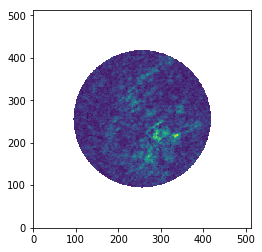

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.facecolor'] = 'white'

from pylab import imshow
from astropy.io import fits
hdu = fits.open('methyl_cyanide/template_noise.fits')
noise_map = hdu[0].data
imshow(noise_map, origin='lower') 

Now, we'll retrieve some values we need for each rung from the methyl cyanide cube table.

In [2]:
from spectral_cube import SpectralCube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

# Get methyl cyanide (target molecule) cube
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [3]:
# Check angular area of pixels:
wcs = ch3cncube.wcs
wcs.proj_plane_pixel_area()

<Quantity 3.08641975e-09 deg2>

In [4]:
# INSTEAD OF WHAT'S AT THE BOTTOM OF THIS CELL, USE THIS (without Tex set):
from lte_modeling_tools import get_molecular_parameters
fmin = 147.035*u.GHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these...
fmax = 147.175*u.GHz # ch3cncube.spectral_axis.max()
ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = get_molecular_parameters('CH3CN', 
                                                                                     fmin=fmin, 
                                                                                     fmax=fmax, 
                                                                                     catalog='JPL')
# We're readying the partition function for use with temperature map later!

from astropy import constants
ch3cn_A = 10**ch3cn_A*u.s**-1 # Original is log_10(A_ij)
ch3cn_E_U = (ch3cn_E_U*u.erg/constants.k_B).decompose() # Original is in erg
print(ch3cn_E_U)

# # from astroquery.splatalogue import Splatalogue
# ch3cntbl = ch3cncube.find_lines(chemical_name='CH3CN', line_lists=['JPL'], 
#                                 show_upper_degeneracy=True, show_qn_code=True)
# ch3cntbl = ch3cntbl[ch3cntbl['Quantum Number Code'] == 202]
# ch3cntbl = ch3cntbl[::-1]
# # ch3cn_freqs = ch3cntbl['Freq-GHz(rest frame,redshifted)']
# # ch3cn_A = 10**ch3cntbl['Log<sub>10</sub> (A<sub>ij</sub>)']
# # ch3cn_g = ch3cntbl['Upper State Degeneracy']
# # ch3cn_E_U = ch3cntbl['E_U (K)'][:,None,None] # This is already divided by the Boltzmann constant, I think?
# ch3cntbl.show_in_notebook()

[381.5879253  288.84656395 210.33731322 146.07815721  96.08362709
  60.36508878  38.93074305  31.78548157] K


In [5]:
ch3cn_A

<Quantity [6.27603981e-05, 1.17246369e-04, 1.63403281e-04, 2.01236068e-04,
           2.30651121e-04, 2.51719255e-04, 2.64307995e-04, 2.68580345e-04] 1 / s>

Now, we'll go through each rung of the ladder and get the upper state column density from the moment 0 map for each rung. We'll store those upper state column density maps for fitting in the next step, and we'll plot the moment 0 maps next to the upper state column density maps for each *k*-component.

We will also propagate errors on the noise map for each of the *k*-components.

In [6]:
import numpy as np
from lte_modeling_tools import nupper_of_kkms
from astropy import constants
import matplotlib.pyplot as plt

log_N_upper_gs = []
log_N_upper_g_errs = []

i = 0
for i in range(0, 8):

    # Import masked cube and get channel width
    masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{i}_masked.fits', format='fits')
    channel_width = np.diff(masked_cube.spectral_axis)[0]

    # Calculate moment 0 and moment 1 maps of cube
    mom0 = masked_cube.moment0()
    mom1 = masked_cube.moment1()
    # Propagate error on integrated intensity
    noise_map_int = noise_map*u.K*(channel_width)

    # Calculate what the shifted line frequency for the rung should be (per pixel) with mom1
    #shifted_line_freqs = (ch3cn_freqs[i]-((mom1/(constants.c.to(u.km/u.s)))*ch3cn_freqs[i])).to(u.GHz) # Maybe okay?

    # Calculate upper state column density from integrated line intensity (moment 0 map)
    N_upper = nupper_of_kkms(mom0, ch3cn_freqs[i], ch3cn_A[i])
#     print(np.nanmean(N_upper))
    log_N_upper_g = np.log10(N_upper.value/ch3cn_g[i]) # Shouldn't have to do .data?
#     print(np.nanmean(log_N_upper_g))
    # Propagate error on upper state column density
    N_upper_err = nupper_of_kkms(noise_map_int, shifted_line_freqs, ch3cn_A[i])
    log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant?

    # Append upper state column density maps and error maps into lists
    log_N_upper_gs.append(log_N_upper_g)
    log_N_upper_g_errs.append(log_N_upper_g_err)
    
    # Plot moment 0 and upper state column density maps for each rung next to each other
#     fig = plt.figure(figsize = (20, 10))
#     im = plt.subplot(1,2,1).imshow(mom0.value, origin='lower', cmap='magma')
# #     plt.colorbar(mappable = im)
#     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Moment 0 Map")
#     im = plt.subplot(1,2,2).imshow(log_N_upper_g, origin='lower', cmap='magma')
# #     plt.colorbar(mappable = im)
#     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Upper State Column Density Map")
#     plt.show()

    print(np.nanmin(log_N_upper_g)) # These values seem a little low
    print(np.nanmax(log_N_upper_g))
    
    i += 1

log_N_upper_gs = np.array(log_N_upper_gs)
log_N_upper_g_errs = np.array(log_N_upper_g_errs)

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


NameError: name 'shifted_line_freqs' is not defined

In [ ]:
masked_cube.max()

masked_cube_test = SpectralCube.read(f'methyl_cyanide/ch3cn_0_masked.fits', format='fits')
np.nanmax(masked_cube_test.moment0())

Lastly, we'll perform parallelized (all pixels at once, along the *k*-component axis) fitting of the upper state column density versus the upper state energy level. We'll start by initializing the values that we're going to fit.

In [ ]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
# set the errors to be huge so these are ignored in the fit
ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs, nan=1e10)

In [ ]:
## Some stuff that didn't work:
# valid_map = np.isfinite(log_N_upper_gs)
# valid_map.shape
# # Build up E_U matrix by hand, to be masked (to go with second fitting attempt)
# E_U_matrix = []
# i = 0
# for i in range(0, 8):
#     new_map = np.ones((512, 512))
#     new_map *= ch3cn_E_U[i,0,0]
#     E_U_matrix.append(new_map)
#     i += 1
# E_U_matrix = np.array(E_U_matrix)
# np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T
# log_N_upper_gs
# np.moveaxis(np.tile(1/(noise_map**2)[:,:,None], 8), 2, 0).shape

## New filtration step:

In [ ]:
# sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # this does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)

ln_N_upper_gs_test = ln_N_upper_gs.copy() # probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # use boolean mask to apply to upper state col densities

ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # now officially applying to data! *****
ln_N_upper_g_errs[ln_N_upper_gs_mask_sum_rep <= 3] = 1e10 # errors big = try to ignore these


Let's do the fitting!

In [ ]:
ch3cn_E_U

In [ ]:
plt.imshow(log_N_upper_gs[5])

In [ ]:
(ch3cn_E_U*u.erg).decompose()

In [ ]:
import matplotlib.pyplot as plt
plt.plot((ch3cn_E_U[::-1]).decompose(), log_N_upper_gs[:,197,298], '.')
#plt.plot((ch3cn_E_U*u.erg/constants.k_B).decompose(), np.log10(np.exp(fitted_m*(ch3cn_E_U)+fitted_b)))
plt.show()

In [ ]:
ln_N_upper_g_errs.shape

In [ ]:
# Original fitting attempt
# ch3cn_E_U_1d = np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T
ch3cn_E_U_1d = np.array([ch3cn_E_U[::-1], np.ones(ch3cn_E_U.shape[0])]).T
fitshape = ln_N_upper_gs.shape[0], np.product(ln_N_upper_gs.shape[1:])
ffr = ln_N_upper_gs.reshape(fitshape)
# ffw = ffr * 1 # Ignoring weights for now 
# zzw = ch3cn_E_U_1d * 1 # Ignoring weights for now

# Do weights stuff: 
#weights = np.mean(ln_N_upper_g_errs, axis=(1,2))
weights = (1/ln_N_upper_g_errs**2).reshape(fitshape)
# this works *if and only if* the weights are dependent on the Z-axis, but not the X- or Y- axis
# so we go back to basics: uniform weights (yikes)
weights = np.ones(8)
# weights = weights.reshape(fitshape)
ffw = ffr * weights[:,None]
zzw = ch3cn_E_U_1d * weights[:,None]

print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")

# Extract fit values
fitted_m = fitted[0].reshape(ln_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
fitted_b = fitted[1].reshape(ln_N_upper_gs.shape[1:]) # m or b? we just don't know
fitted_resid = residuals.reshape(ln_N_upper_gs.shape[1:])

temperature = -1./fitted_m # okay, we are assuming that this is the correct interpretation of m vs. b
temperature = (temperature*u.erg/constants.k_B).decompose()
ln_intercept = fitted_b
# log_intercept = np.log10(np.exp(ln_intercept)) # Log base 10 of (e to the [natural log of N])

## This is wrong:
# temperature_alt = -1./fitted_b
# ln_N_alt = fitted_m
# log_N_alt = np.log10(np.exp(ln_N_alt))

In [ ]:
ffr.shape

In [ ]:
# log_N[196,291]

Let's do one last modification to make the total column density correct: including the partition function in the calculation. (One day I'll clean up this notebook and make it readable and consistent...)

In [ ]:
# N_tot = intercept * Z, so ln_N_tot = ln_intercept + ln_Z
Z = ch3cn_partfunc(temperature)
ln_Z = np.log(Z)
ln_N_tot = ln_intercept + ln_Z
log_N_tot = np.log10(np.exp(ln_N_tot)) # Log base 10 of (e to the [natural log of N])

Then, let's plot the values we get!

In [ ]:
# Plot results
fig = plt.figure(figsize = (15, 15))
im = plt.subplot(2,2,1).imshow(temperature.value, origin='lower', cmap='magma', vmax=500, vmin=0); plt.colorbar(mappable = im, fraction=0.046, pad=0.04) # , vmin=0, vmax=100
plt.title("Temperature (K)")
im = plt.subplot(2,2,2).imshow(log_N_tot, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
plt.title("Column density ($\log_{10}(N_{tot})$)")
# im = plt.subplot(2,2,3).imshow(temperature_alt, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
# plt.title("Temperature (K, alternate)")
# im = plt.subplot(2,2,4).imshow(log_N_alt, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
# plt.title("Column density (units?, alternate)")
# im = plt.subplot(2,2,4).imshow(fitted_resid, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted residuals")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.savefig(f'/blue/adamginsburg/abulatek/brick/first_results/prelim_temp_map.pdf')
plt.show()

# Making colorbars smaller
# https://stackoverflow.com/questions/16702479/matplotlib-colorbar-placement-and-size

export temp and col density

In [ ]:
header = hdu[0].header
fits.PrimaryHDU(data=temperature.value, header=header).writeto('temperature_map_test.fits', overwrite=True)
fits.PrimaryHDU(data=log_N_tot, header=header).writeto('log_N_tot_test.fits', overwrite=True)

Now, let's make a histogram of the temperature values.

In [ ]:
temperature[~np.isinf(temperature)].shape
# np.histogram(temperature[~np.isinf(temperature)])
n, bins, patches = plt.hist(temperature[~np.isinf(temperature)], bins=100)
plt.yscale('log')
# plt.xlim(-1000, 1000)
plt.xlabel("Fitted temperature value (K)")
plt.ylabel("Counts per bin")
plt.show()

print("Pixels fitted:",temperature.shape[0]*temperature.shape[1]) # How many temperature values did we calculate? (2D)
print("Above zero:",np.sum(temperature > 0)) # How many of the values are above zero?
print("Equal to zero:",np.sum(temperature == 0.0)) # How many values are equal to zero?

Because I don't trust that I did these fits correctly, let's visualize one of the rotational diagrams. I will do this for the pixel with the maximum upper state column density for the *k* = 0 line.

In [ ]:
ln_N_upper_gs_mask_sum.max()

In [ ]:
# test = [0, 1, 2, 3]
# test2 = test.copy()

all_comp_coord = np.unravel_index(np.argmax(ln_N_upper_gs_mask_sum), 
                                  temperature.shape)

In [ ]:
# Plot rotational diagram for a pixel
max_temp_coord = np.unravel_index(np.nanargmax(temperature), 
                                  temperature.shape)
print(max_temp_coord)

# temperature_new = temperature.copy()
# temperature_new[max_temp_coord[0], max_temp_coord[1]] == np.nan
# max_temp_coord_new = np.unravel_index(np.nanargmax(temperature_new), 
#                                       temperature_new.shape)
# print(max_temp_coord_new)

example_N_upper = ln_N_upper_gs[:, all_comp_coord[0], all_comp_coord[1]]
example_E_upper = ch3cn_E_U

print(example_E_upper)

#plt.style.use('dark_background')

fig = plt.figure(figsize=(7, 4))
plt.scatter(example_E_upper.value, example_N_upper)
plt.ylabel("$\log (N_u / g)$")
plt.xlabel("$E_u / k$ (K)")
# plt.ylim(9.30225, 9.30275)
plt.text(2.7e9, 25, f"T = {np.nanargmax(temperature)} K")
plt.text(2.7e9, 24.6, f"Coordinate = {max_temp_coord}")
plt.show()

### synthetic spectrum

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (80, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 109548373997.542 Hz:111422149820.383 Hz


invalid value encountered in true_divide
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


HNCO AxesSubplot(0.125,0.657941;0.775x0.222059)
CH3CN AxesSubplot(0.125,0.391471;0.775x0.222059)


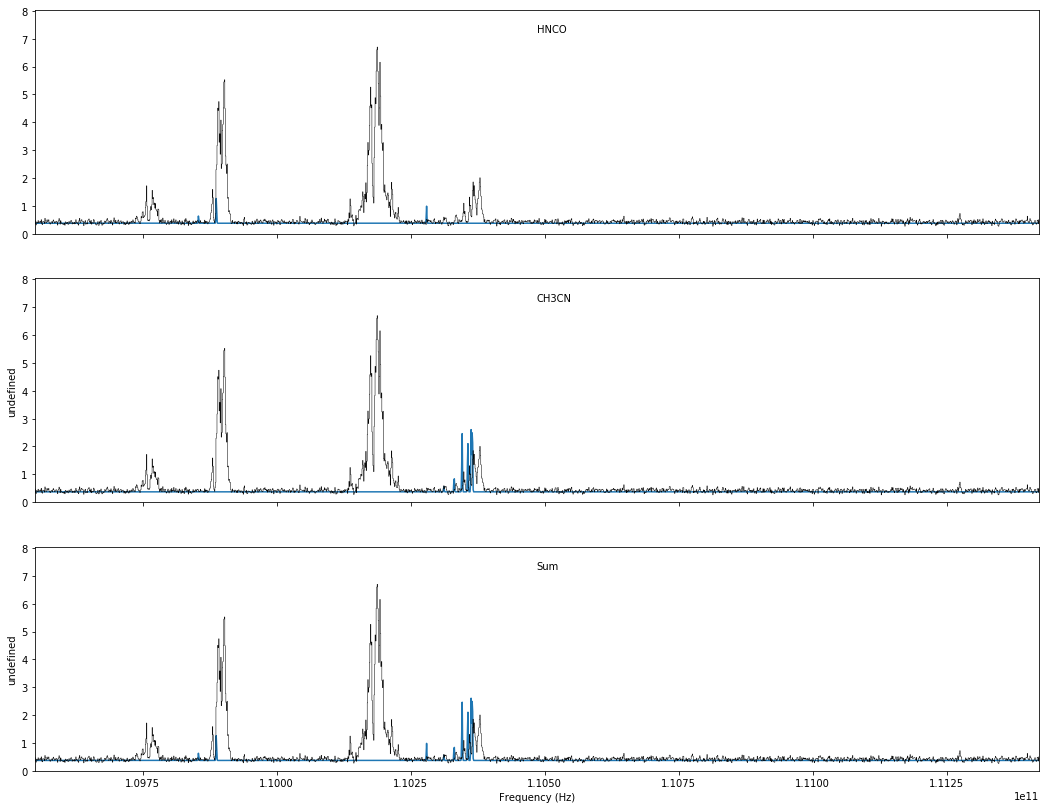

In [8]:
# Synthetic spectrum
%run /blue/adamginsburg/abulatek/brick/first_results/LTE/reworked_LTE_lineforest.py

In [9]:
fmin = 110330.34*u.MHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these...
fmax = 110383.6*u.MHz # ch3cncube.spectral_axis.max()
ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = get_molecular_parameters('CH3CN', 
                                                                                     fmin=fmin, 
                                                                                     fmax=fmax, 
                                                                                     catalog='JPL')
# used to be 'CH3CN' as first argument
print(ch3cn_E_U)

[2.72125848e-14 1.83403306e-14 1.14376093e-14 6.50595053e-15
 3.54652619e-15 2.55997195e-15]


In [10]:
mod = np.nansum(mods,axis=0)*fillingfactor
mod_sp = pyspeckit.Spectrum(data = mod*u.K, xarr = sp.xarr.copy())

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


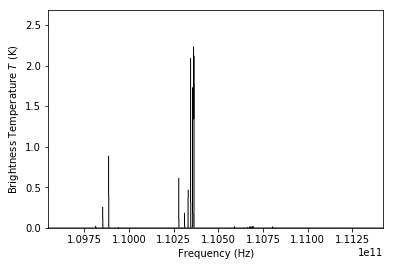

In [11]:
# pl.figure()
mod_sp.plotter(figure = pl.figure())

In [12]:
ch3cn_freqs[2]

<Quantity 110364.3537 MHz>

In [13]:
# Rework model so it has higher spectral resolution (sample the peak better)

In [14]:
ch3cn_freqs

<Quantity [110330.345 , 110349.4703, 110364.3537, 110374.989 , 110381.372 ,
           110383.4999] MHz>

In [15]:
import warnings
warnings.simplefilter('ignore')

110330.345 MHz 0.6943485596802892 K km / s 10.270343659861249
110349.4703 MHz 2.245739680516507 K km / s 10.520434149269272
110364.3537 MHz 8.826939609557737 K km / s 10.68342452840513
110374.989 MHz 7.268016536715196 K km / s 10.826284881131214
110381.372 MHz 10.221274955036158 K km / s 10.935431310532756
110383.4999 MHz 13.838149089203542 K km / s 11.054757500201044


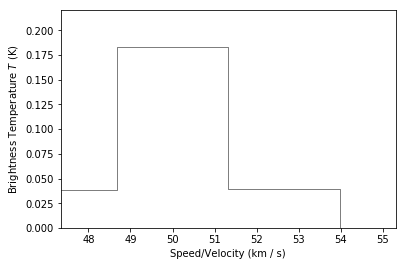

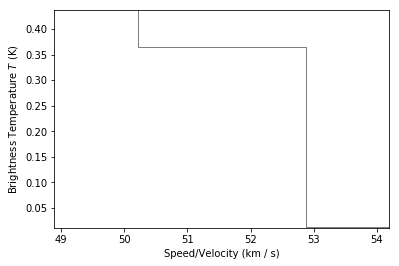

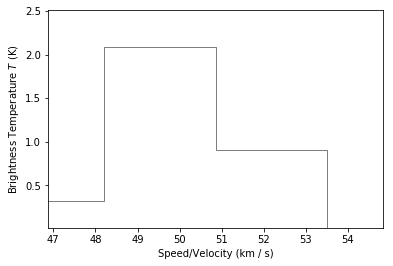

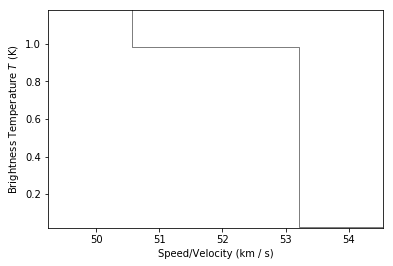

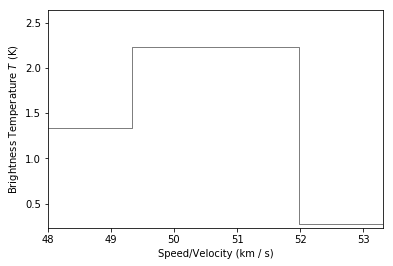

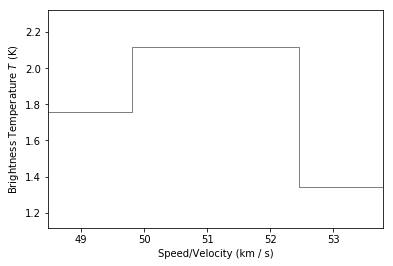

In [16]:
from lte_modeling_tools import nupper_of_kkms

log_N_upper_gs = []
for freq, AA, gg in zip(ch3cn_freqs, ch3cn_A, ch3cn_g):
    # Use velocity to get freq centers for each line
    mod_sp.xarr.convert_to_unit(u.km/u.s, refX = freq, velocity_convention='radio')
    # Get spectral slice for each line
    v_c = 50*u.km/u.s
    new_sp = mod_sp.slice(v_c - 4.5*u.km/u.s, v_c + 4.5*u.km/u.s) # , unit = u.km/u.s
    new_sp.plotter(figure = pl.figure())
    # Sum slice and multiply by channel width
    mom0 = new_sp.data.sum()*u.K*np.abs(new_sp.xarr.cdelt())
    # Convert back to freq
    mod_sp.xarr.convert_to_unit(u.Hz)
    N_upper = nupper_of_kkms(mom0, freq, 10**AA)
    #     print(np.nanmean(N_upper))
    log_N_upper_g = np.log10(N_upper.value/gg) # Shouldn't have to do .data?
    #     print(np.nanmean(log_N_upper_g))

    # Append upper state column density maps and error maps into lists
    log_N_upper_gs.append(log_N_upper_g)
    print(freq, mom0, log_N_upper_g)

In [26]:
# checking units
ch3cn_E_U

array([2.72125848e-14, 1.83403306e-14, 1.14376093e-14, 6.50595053e-15,
       3.54652619e-15, 2.55997195e-15])

In [17]:
ln_N_upper_gs = np.log(10**np.array(log_N_upper_gs))

In [18]:
ch3cn_partfunc(100*u.K)

2114.151278505822

In [19]:
ln_N_upper_gs.shape[1:]

()

In [27]:
ch3cn_E_U

array([2.72125848e-14, 1.83403306e-14, 1.14376093e-14, 6.50595053e-15,
       3.54652619e-15, 2.55997195e-15])

In [20]:
ch3cn_E_U_1d = np.array([ch3cn_E_U, np.ones(ch3cn_E_U.shape[0])]).T
fitshape = ln_N_upper_gs.shape[0], np.product(ln_N_upper_gs.shape[1:]).astype('int')
ffr = ln_N_upper_gs.reshape(fitshape)
# ffw = ffr * 1 # Ignoring weights for now 
# zzw = ch3cn_E_U_1d * 1 # Ignoring weights for now

# Do weights stuff: 
# weights = np.mean(ln_N_upper_g_errs, axis=(1,2))
# weights = weights.reshape(fitshape)
weights = np.ones_like(ln_N_upper_gs)
ffw = ffr * weights[:,None]
zzw = ch3cn_E_U_1d * weights[:,None]

print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")

# Extract fit values
fitted_m = fitted[0].reshape(ln_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
fitted_b = fitted[1].reshape(ln_N_upper_gs.shape[1:]) # m or b? we just don't know
fitted_resid = residuals.reshape(ln_N_upper_gs.shape[1:])

temperature = -1./fitted_m # okay, we are assuming that this is the correct interpretation of m vs. b
ln_intercept = fitted_b

ffw.shape=(6, 1), zz1d.shape=(6, 2)
rank=2, singular=[2.44948974e+00 2.14881623e-14]


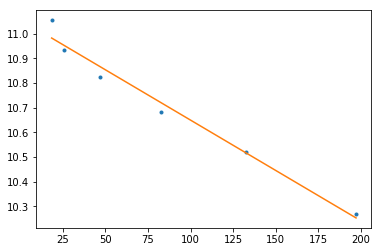

In [29]:
import matplotlib.pyplot as plt
plt.plot((ch3cn_E_U*u.erg/constants.k_B).decompose(), log_N_upper_gs, '.')
plt.plot((ch3cn_E_U*u.erg/constants.k_B).decompose(), np.log10(np.exp(fitted_m*(ch3cn_E_U)+fitted_b)))
plt.show()

In [22]:
fitted

array([[-6.81293632e+13],
       [ 2.54627931e+01]])

In [23]:
(temperature*u.erg/constants.k_B).decompose()

<Quantity 106.31202425 K>

In [24]:
np.log10(np.exp(ln_intercept)*ch3cn_partfunc(100*u.K))

14.383486590207264

## STOP HERE

How would I incorporate an "only fit if more than three significantly-detected lines" clause? --- I incorporated this in "new filtration step" above!

In [ ]:
# Could be a single line thing... for a given pixel, if less than three k-components have a non-NaN
# value, replace all k-components with NaN (or whatever value the other k-components are covered with
# in those upper state column density maps).

In [ ]:
# # you can mask a cube like this:
# plain_mask = cube1vel >= 3 * mad_std_map_sclip # Get plain 3sigma mask
# plain_masked_slab = cube1vel.with_mask(plain_mask) # Mask the template molecule cube
# # if I was going to do this with just arrays, I'd do smth like:
# plain_masked_slab = cube1vel[cube1vel >= 3*mad_std_map_sclip]

# sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # this does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)

ln_N_upper_gs_test = ln_N_upper_gs.copy() # probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # use boolean mask to apply to upper state col densities

ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # now officially applying to data! *****

# ln_N_upper_gs_test

# ln_N_upper_gs_mask_sum[:,:,None].shape # Adam's suggestion; not super sure how to make it work
# ln_N_upper_gs_test = np.where(ln_N_upper_gs_mask_sum <= 3, 0, ln_N_upper_gs) # condition, meet, does not meet

In [ ]:
# Unit test; when officially applied, both should match
print(ln_N_upper_gs[:,196,291], ln_N_upper_gs_test[:,196,291]) # this pixel should not be changed
print(ln_N_upper_gs[:,206,291], ln_N_upper_gs_test[:,206,291]) # this pixel SHOULD be changed to all zeros

Checking frequency separations:

In [ ]:
ch3cn_freqs

In [ ]:
# Frequency separations between J = 8 k-components
frequency_seps = []
for i in range(len(ch3cn_freqs) - 1):
    sep = (ch3cn_freqs[i]*u.GHz - ch3cn_freqs[i + 1]*u.GHz).to(u.MHz)
    frequency_seps.append(sep.value)
print(frequency_seps*u.MHz)

In [ ]:
# Line shift caused by 20 km/s velocity component
print(((ch3cn_freqs*u.GHz)*(20.*u.km/u.s)/((constants.c).to(u.km/u.s))).to(u.MHz))
# Line shift caused by 80 km/s velocity component
print(((ch3cn_freqs*u.GHz)*(80.*u.km/u.s)/((constants.c).to(u.km/u.s))).to(u.MHz))

In [ ]:
# # Second fitting attempt

# # Apply valid map to both independent and dependent variables
# E_U_valid = E_U_matrix[valid_map]
# log_N_upper_gs = log_N_upper_gs[valid_map] # This is rewriting this variable, which is a bad practice

# # ch3cn_E_U_1d = np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T # what are the ones?
# fitshape = log_N_upper_gs.shape[0] #, np.product(log_N_upper_gs.shape[1:])
# ch3cn_E_U_1d = E_U_valid.reshape(fitshape)
# ffr = log_N_upper_gs.reshape(fitshape)
# print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
# fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
# print(f"rank={rank}, singular={singular}")
# fitted_m = fitted[0].reshape(log_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
# fitted_b = fitted[1].reshape(log_N_upper_gs.shape[1:])
# fitted_resid = residuals.reshape(log_N_upper_gs.shape[1:])

# # Plot results
# fig = plt.figure(figsize = (15, 15))
# im = plt.subplot(2,2,1).imshow(fitted_m, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted $m$")
# im = plt.subplot(2,2,2).imshow(-1./fitted_m, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted temperature ($-1/m$; K)")
# im = plt.subplot(2,2,3).imshow(fitted_b, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted $b$")
# im = plt.subplot(2,2,4).imshow(-1./fitted_b, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted temperature ($-1/b$; K)")
# # im = plt.subplot(2,2,4).imshow(fitted_resid, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# # plt.title("Fitted residuals")
# plt.show()

Verification step:

In [ ]:
# print(np.sum(np.isfinite(temp)))
# # test_arr = np.array([[1, np.nan, 4, np.nan],[np.nan, np.nan, 6, 7],[np.nan, 5, 8, 10]])
# # test_arr_2 = np.array([[1, np.nan, np.nan, np.nan],[np.nan, np.nan, 6, 7],[np.nan, 5, 8, 10]])
# # print(test_arr)
# # print(np.isfinite(test_arr))
# # print(np.sum(np.isfinite(test_arr)))
# # print(np.isfinite(test_arr) & np.isfinite(test_arr_2))
# all_finite = np.isfinite(log_N_upper_gs[0]) & \
#                 np.isfinite(log_N_upper_gs[1]) & \
#                 np.isfinite(log_N_upper_gs[2]) & \
#                 np.isfinite(log_N_upper_gs[3]) & \
#                 np.isfinite(log_N_upper_gs[4]) & \
#                 np.isfinite(log_N_upper_gs[5]) & \
#                 np.isfinite(log_N_upper_gs[6]) & \
#                 np.isfinite(log_N_upper_gs[7])
# print(np.sum(all_finite))
# # If both the same number, then we know np.linalg.lstsq doesn't fit a pixel if it contains a NaN

Let's try this new math with a known temperature.

In [ ]:
# User inputs
T = 100*u.K # Temperature (in K)
N = 500 # Total column density (units?)

E_upper = ch3cn_E_U # Upper state energies (in K)
g_upper = ch3cn_g # Degeneracies corresponding to upper state energies

# Generate upper state column densities
N_upper = g_upper*N*np.exp(-(E_upper*u.K)/T)

# Try to get total column density and temperature out of linear fit

ln_N_upper_gs = np.log(N_upper/g_upper) # Is this valid, or should I be doing this differently?

ch3cn_E_U_1d = np.array([E_upper[:,0,0], np.ones(E_upper.shape[0])]).T
fitshape = ln_N_upper_gs.shape[0], np.product(ln_N_upper_gs.shape[1:])
ffr = ln_N_upper_gs.reshape(fitshape)
ffw = ffr * 1 # Ignoring weights for now 
zzw = ch3cn_E_U_1d * 1 # Ignoring weights for now

# # Do weights stuff: 
# weights = ln_N_upper_g_errs
# weights = weights.reshape(fitshape)
# ffw = ffr * weights[:,None]
# zzw = ch3cn_E_U_1d * weights[:,None]

print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")

# Extract fit values
fitted_m = fitted[0].reshape(ln_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
fitted_b = fitted[1].reshape(ln_N_upper_gs.shape[1:]) # m or b? we just don't know
fitted_resid = residuals.reshape(ln_N_upper_gs.shape[1:])

temperature = -1./fitted_m
ln_N = fitted_b
log_N = np.log10(np.exp(ln_N)) # Log base 10 of (e to the [natural log of N])

temperature_alt = -1./fitted_b
ln_N_alt = fitted_m
log_N_alt = np.log10(np.exp(ln_N_alt))

# Comparison to see if fitting works
print(f"Input temperature: {T}")
print(f"Fitted temperature: {temperature}")
print(f"Input total column density: {N}")
print(f"Fitted total column density: {10**(log_N)}")

### Adam's code for parallelized fitting

In [ ]:
import pylab as pl
# make x,y axes
yy,xx = np.indices([23,17])
zz = np.linspace(0,1,5)[:,None,None]
# this works *if and only if* the weights are dependent on the Z-axis, but not the X- or Y- axis
weights = np.random.rand(zz.shape[0])
# f = mm * zz + bb
## mm, bb are arbitrarily selected
mm = 0.5 * np.log10(xx+0.1) + 2.5 * np.log(yy+0.1)
bb = yy-xx
ff = mm*zz + bb
zz1d = np.array([zz[:,0,0], np.ones(zz.shape[0])]).T
fitshape = ff.shape[0], np.product(ff.shape[1:])
ffr = ff.reshape(fitshape)
ffw = ffr * weights[:,None]
zzw = zz1d * weights[:,None]
print(f"ffw.shape={ffw.shape}, zz1d.shape={zz1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")
fitted_m = fitted[0].reshape(ff.shape[1:])
fitted_b = fitted[1].reshape(ff.shape[1:])
fitted_resid = residuals.reshape(ff.shape[1:])
# verify again
_=pl.figure(figsize=(15,15))
im=pl.subplot(3,3,1).imshow(mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,2).imshow(fitted_m); pl.colorbar(mappable=im)
im=pl.subplot(3,3,3).imshow(fitted_m-mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,4).imshow(bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,5).imshow(fitted_b); pl.colorbar(mappable=im)
im=pl.subplot(3,3,6).imshow(fitted_b-bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,8).imshow(fitted_resid); pl.colorbar(mappable=im)

In [ ]:
weights[:,None].shape